# Tensorflow used to Predict Petrophysical Properties:

Tensorflow used to Estimate the Mode (microns) of the Pore Throat Distribution from porosity and permeability data calibrated to Clerke's Rosetta Stone Arab D Carbonate dataset.
### Introduction
#### Predict Mode of Pore Throats
The objective of this project is to estimate the Mode of the Pore Throat Distribution which would then let us segregate the rock into Macro, Meso and Micro Rock Types (RTs). In this repository we are using Tensorflow  to predict Mode. 

The Arab D data set published by Clerke is quite distinctive. Clerke acquired nearly 450 High Pressure Mercury Injection Capillary Pressure (HPMI) measurements in the Arab D reservoir; however, Clerke's final samples were randomly selected from 1,000's of pre-qualified core samples ensuring a broad distribution and representation of all Petrophysical properties. This created one of the best Core Analysis datasets every collected in our industry. 

Clerke began evaluating this dataset by fitting a Thomeer hyperbolas for each pore system in each sample to generate the published Thomeer Capillary Pressure parameters. From these data Clerke established his Petrophysical Rock Types (PRT) based on the Initial Displacement Pressures for each pore system and the number of pore systems present in each sample. From the figure below it is rather evident that Clerke's PRTs are Petrophysically well-defined in poro-perm space where each color represents a different PRT.  The Capillary Pressure curves and Pore Throat Distributions (PTD) shown on the right hand side of the figure illustrate the unique characteristics of each PRT. 

![TS_Image](PRT.png)

###### The characterization of Clerke's PRTs are shown below:

![TS_Image](Rock-Types.png)

As can be seen in the first figure above, the PRTs are rather well segregated in the Porosity vs. Permeability Cross Plot as they fall in distinct regions or clusters on the Cross Plot.For modeling purposes it is important to take advantage of the excellent correlations between the PRTs. 

This notebook was started from Aman Bhandula's GitHub repository:

https://github.com/Amanbhandula/Prediction-of-reservoir-properties-using-Neural-Network

We used Clerke's Rosetta Stone data and his PRTs as our training set, except that we combined all the macros PRTs into one RT that had a value of 2. We combined all the Type 1 Meso PRT into a RT with a value of 1 and all the Micro PRT compose our third RT with a value of 0. The following is the standard Sigmoid s-curve.

We are using Tensorflow to predict the log10 of the Mode from Porosity and log10 of Permeability. 

Run 1:
We initally make the first training run (Run 1) using 20% of the data for testing with Epochs > 100. Save the training weights from Run 1. 

        #1st run - run > 100 epochs with 20% of the data first for training
        from sklearn.model_selection import train_test_split
        df_train, df_test = train_test_split(df, test_size=0.2)


        '''
        Save the checkpoint training weights and load them again if needed per lines below:
        '''
        if epochs > 100: 
            if input('Save model ? [Y/N]') == 'Y':
                saver.save(sess,'./datsa/yahoo_dataset.ckpt')
                print('Model Saved') 

Run 2:
In the second run we use all the data for Mode predictions (pred) at each sample level in our dataset. We use 0 Epochs and restore the training weights per the code below.

        #2nd run - now define zone of interest and use checkpoints from training before
        df_train = df[:328]   
        df_test = df[0:]       

        saver.restore(sess,'./data/yahoo_dataset.ckpt')




1 Clerke, E. A., Mueller III, H. W., Phillips, E. C., Eyvazzadeh, R. Y., Jones, D. H., Ramamoorthy, R., Srivastava, A., (2008) “Application of Thomeer Hyperbolas to decode the pore systems, facies and reservoir properties of the Upper Jurassic Arab D Limestone, Ghawar field, Saudi Arabia: A Rosetta Stone approach”, GeoArabia, Vol. 13, No. 4, p. 113-160, October 2008. 

---
# Load Tensorflow and other requirements:

In [1]:
import pandas as pd
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#import tensorflow as tf
print(tf.version.VERSION)

import time

Instructions for updating:
non-resource variables are not supported in the long term
2.8.0


---
# Load Data
 
## Load Excel file using pandas read_excel:

In [2]:
file = r'./data/RosettaStone_mode_tf.xlsx'
data = pd.read_excel(file,  index_col='Sample')
data.head()

,Porosity,Perm,Mode
Sample,,,
1,0.26043,2034.6025,100.05
2,0.25810,4800.0000,94.16
3,0.27417,1651.9321,85.88
4,0.28101,3185.1145,79.61
5,0.23313,1896.5830,79.21


**This loads the core porosity, Permeability and Mode of Pore Throat Distribution (PTD)**

The exact Mode of the PTD (microns) is calculated using Clerke's Thomeer Capillary Pressure parameters:

            mode (microns) = exp(-1.15*G1)/(214/Pd1)
        
Since the Mode is lognormal in distribution like permeability, we will be using the log10 of the Mode in our work.


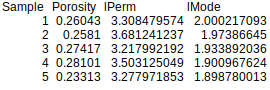

## Create Pandas DataFrame df for our data, and take the log10 of Permeability and Mode:

In [3]:
por_max = 0.4
por_min = 0.0


perm_max =  4.0
perm_min = -4.0

mode_max =  2.0
mode_min = -2.0

norm_array    = []
Porosity      = []
lPerm         = []
lMode         = []

#this is the mapinv_reference_data being used 
for i in range(1,len(data)+1,1):

    Porosity.append(data['Porosity'][i] )
    lPerm.append(np.log10(data['Perm'][i]) )
    lMode.append(np.log10(data['Mode'][i]))

for i in range(0,len(data),1):    
    norm_array.append([Porosity[i] , lPerm[i] , lMode[i]])
    
df = pd.DataFrame(norm_array, columns=['Porosity','lPerm','lMode'])
df.head()

,Porosity,lPerm,lMode
0,0.26043,3.308480,2.000217
1,0.25810,3.681241,1.973866
2,0.27417,3.217992,1.933892
3,0.28101,3.503125,1.900968
4,0.23313,3.277972,1.898780


In [4]:
print(len(df))

328


# Depth Plots of data:
### Porosity:

(328.0, 1.0)

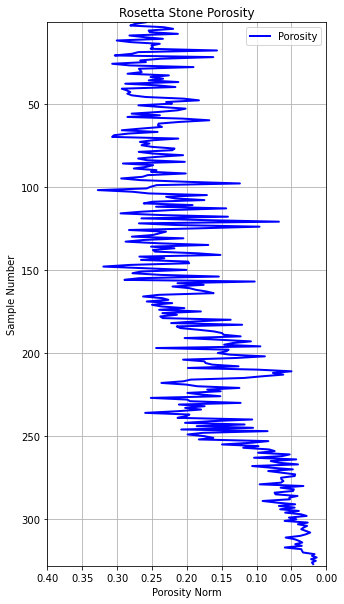

In [5]:
plt.figure(figsize=(5,10))
#plt.plot(data.index, Porosity)
plt.plot(df['Porosity'] ,df.index,label="Porosity",c="b",linewidth=2)
plt.xlabel("Porosity Norm")
plt.ylabel("Sample Number")
plt.title("Rosetta Stone Porosity")
plt.legend(loc='best')
plt.grid(True)
plt.xlim(0.4,0)
plt.ylim(max(data.index),min(data.index))

### Permeability:

(328.0, 1.0)

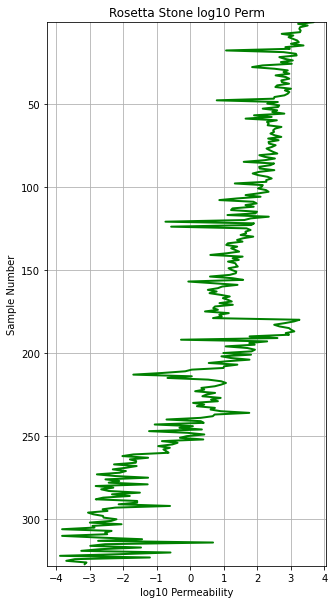

In [6]:
plt.figure(figsize=(5,10))
#plt.semilogx(data.index, data["Perm"])
plt.plot(df['lPerm'], df.index,color='green',linewidth=2)
plt.xlabel("log10 Permeability")
plt.ylabel("Sample Number")
plt.title("Rosetta Stone log10 Perm")
plt.grid(True)
#plt.xlim(0.0,1)
plt.ylim(max(data.index),min(data.index))

### Mode of Pore Throat Distribution:

(328.0, 1.0)

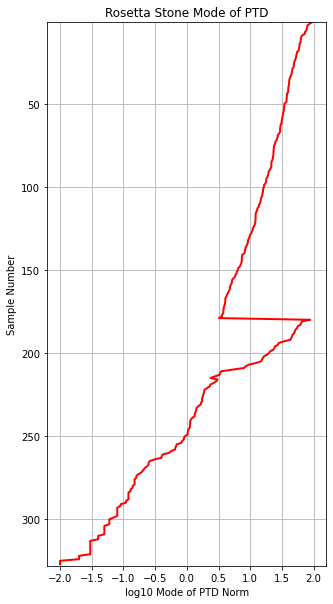

In [7]:
plt.figure(figsize=(5,10))
plt.plot(df['lMode'], df.index,c="r",linewidth=2)
plt.xlabel("log10 Mode of PTD Norm")
plt.ylabel("Sample Number")
plt.title("Rosetta Stone Mode of PTD")
plt.grid(True)
#plt.xscale("log")
#plt.xlim(0.0,1)
plt.ylim(max(data.index),min(data.index))

## Seaborn Plot of data:

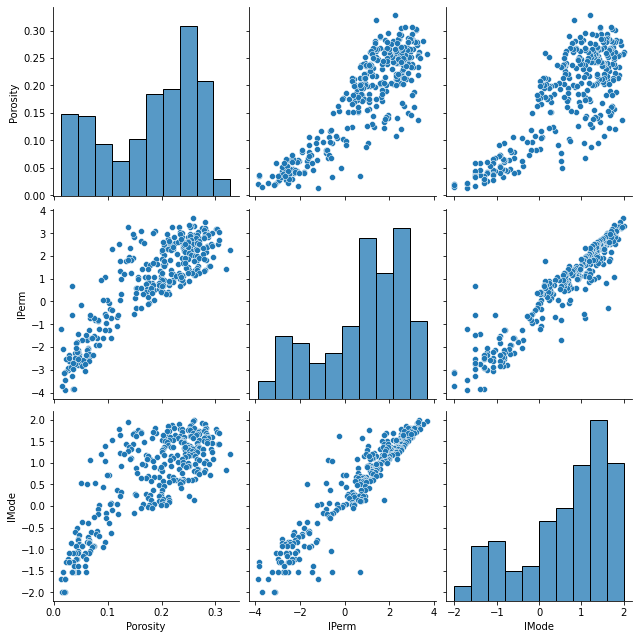

In [8]:
sns.pairplot(df.dropna(),height=3)

## Condition DataFrame:

In [9]:
df.head()
df = df.dropna()
df.fillna(-9999999999)
df.isnull().any()
#df

Porosity    False
lPerm       False
lMode       False
dtype: bool

In [10]:
df.describe()

,Porosity,lPerm,lMode
count,328.000000,328.000000,328.000000
mean,0.179793,0.822339,0.624650
std,0.084690,1.896082,1.031316
min,0.013870,-3.886057,-2.000000
25%,0.104705,-0.336976,0.040319
50%,0.202105,1.249908,0.940413
75%,0.250075,2.354566,1.457353
max,0.327590,3.681241,2.000217


# Split data into Training and Test data:
## Run 1:  For inital training use train_test_split for random training/test data
## Run 1:  Enable df_train, df_test = train_test_split(df, test_size=0.2)

# Single out Curve to predict:
### Drop Curve being predicted and normalize from -2 to 2 using Sklearn method.
#### Apply to both Training and Test datasets.

In [11]:
#correct_labels = df['Mode_norm'].values
correct_labels = df['lMode'].values


# works great feature_vectors = df.drop(['Mode_norm', 'Porosity','Perm','Mode','lPerm','lMode'], axis=1)
feature_vectors = df.drop(['lMode'], axis=1)

In [12]:
print(len(correct_labels), len(feature_vectors))

328 328


In [13]:
feature_vectors.describe()

,Porosity,lPerm
count,328.000000,328.000000
mean,0.179793,0.822339
std,0.084690,1.896082
min,0.013870,-3.886057
25%,0.104705,-0.336976
50%,0.202105,1.249908
75%,0.250075,2.354566
max,0.327590,3.681241


# Use Sklearn to  to normalize our data:

In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [15]:
scaled_features[:1]

array([[0.95359783, 1.31320185]])

## Work from Sklearn preprocessed normalized data and create training and test data:

In [16]:
from sklearn.model_selection import train_test_split

#feature_vectors2=np.array(feature_vectors)


#X_train, X_test, y_train, y_test = train_test_split(
#     feature_vectors2, correct_labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_labels, test_size=0.2, random_state=42)

In [17]:
print('Test' , max(y_test),min(y_test),len(y_test))
print('Train', max(y_train),min(y_train),len(y_train))

Test 1.9009676239191242 -2.0 66
Train 2.00021709297223 -2.0 262


In [18]:
print(len(X_test))

66


# Define Our Neural Network Model:

In [19]:
"""
neural_net_model is function applying 2 hidden layer feed forward neural net.
Weights and biases are abberviated as W_1, W_2 and b_1, b_2 
These are variables with will be optomized during training.
"""
def neural_net_model(X_data,input_dim):
    
    # layer 1 multiplying and adding bias then activation function
    W_1     = tf.Variable(tf.random_uniform([input_dim, 10]))
    b_1     = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data, W_1), b_1)
    layer_1 = tf.nn.relu(layer_1)
    
    # layer 2 multiplying and adding bias then activation function
    W_2     = tf.Variable(tf.random_uniform([10,10]))
    b_2     = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1, W_2), b_2)
    layer_2 = tf.nn.relu(layer_2)

    # O/p layer multiplying and adding bias then activation function
    # notice output layer has one node only since performing #regression    
    W_O     = tf.Variable(tf.random_uniform([10, 1]))
    b_O     = tf.Variable(tf.zeros([1]))
    output  = tf.add(tf.matmul(layer_2, W_O), b_O)
    return output


    
    
xs     = tf.placeholder("float")
ys     = tf.placeholder("float")

'''
  - This is the number of training curves being used:
  *************   
'''
output = neural_net_model(xs,2)  # 2 training curves
'''
  *************   
'''

# our mean squared error cost function
cost   = tf.reduce_mean(tf.square(output-ys))

# Gradinent Descent optimiztion just discussed above for updating weights and biases
train  = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

##output is <tf.Tensor 'Add_8:0' shape=<unknown> dtype=float32>
#cost <tf.Tensor 'Mean_3:0' shape=() dtype=float32>
#train <tf.Operation 'GradientDescent_4' type=NoOp>

# Training with Many Epochs in Tensorflow:
### 1) Run 1: Run 100 - 1,000 epochs using 20% training set and save weights. 
**You could turn on restore weights on run 1 epoch after training after restoring the training weights**

Begin Training
Metal device set to: Apple M1 Pro


2022-03-09 20:11:26.896648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 20:11:26.897054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-09 20:11:26.903283: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-09 20:11:26.903797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-09 20:11:26.959287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-09 20:11:27.681712: I tensorflow/core/grappler/o

Epoch : 0 Cost : 1.4351556
Epoch : 1 Cost : 1.4219017
Epoch : 2 Cost : 1.4224021
Epoch : 3 Cost : 1.427034
Epoch : 4 Cost : 1.4371426
Epoch : 5 Cost : 1.455831
Epoch : 6 Cost : 1.4775876
Epoch : 7 Cost : 1.5000243
Epoch : 8 Cost : 1.5231234
Epoch : 9 Cost : 1.5454767
Epoch : 10 Cost : 1.5682198
Epoch : 11 Cost : 1.5909252
Epoch : 12 Cost : 1.6124858
Epoch : 13 Cost : 1.6328199
Epoch : 14 Cost : 1.651326
Epoch : 15 Cost : 1.6675342
Epoch : 16 Cost : 1.6821585
Epoch : 17 Cost : 1.6954195
Epoch : 18 Cost : 1.7076677
Epoch : 19 Cost : 1.7190428
Epoch : 20 Cost : 1.7292063
Epoch : 21 Cost : 1.738712
Epoch : 22 Cost : 1.7470052
Epoch : 23 Cost : 1.7545265
Epoch : 24 Cost : 1.7607512
Epoch : 25 Cost : 1.7659559
Epoch : 26 Cost : 1.7697692
Epoch : 27 Cost : 1.7728412
Epoch : 28 Cost : 1.7763088
Epoch : 29 Cost : 1.7796519
Epoch : 30 Cost : 1.7816695
Epoch : 31 Cost : 1.7803649
Epoch : 32 Cost : 1.7788284
Epoch : 33 Cost : 1.7780771
Epoch : 34 Cost : 1.776693
Epoch : 35 Cost : 1.7777599
Epoch :

Epoch : 288 Cost : 1.882217
Epoch : 289 Cost : 1.898897
Epoch : 290 Cost : 1.8827099
Epoch : 291 Cost : 1.8816283
Epoch : 292 Cost : 1.8994958
Epoch : 293 Cost : 1.8824403
Epoch : 294 Cost : 1.882888
Epoch : 295 Cost : 1.8982002
Epoch : 296 Cost : 1.881642
Epoch : 297 Cost : 1.8992003
Epoch : 298 Cost : 1.8818487
Epoch : 299 Cost : 1.8822906


2022-03-09 20:14:38.022613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


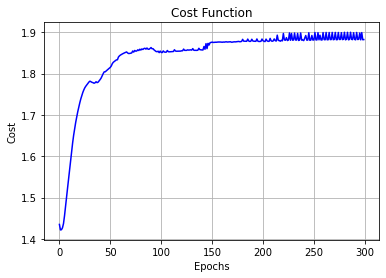

Model Saved
Total Time Taken: 191.12638688087463 seconds or Minutes Taken: 3.1854397813479105
Average Time Per Epoch: 0.6370879562695821


2022-03-09 20:14:38.070521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
c_t    = []
c_test = []
count  = []


print("Begin Training")
start_time = time.time()

epochs = 300 # with 20% training
#epochs =  2 # over all the data

with tf.Session() as sess:

    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    
    '''
    In case you save weights, this is called at the end
    '''
    saver = tf.train.Saver()
    #############saver = tf.train.Checkpoint()
    
    '''
    This next line will load the previous weights just the way it is written.
    It appears to be best to use 20% of random data to train with 50-100 epochs,
    and save the weights from that.
    
    Then load those weights using saver.restore over the zone of interest, 
    and use only 2-5 epochs on the zone of interest + previous checkpoints.
    '''
    #####saver.restore(sess,'rosettastone_dataset.ckpt')
    
    for i in range(epochs):
        for j in range(X_train.shape[0]):
            '''
            the reshape(1,10) or (1, x ) x is number of curves used for training is set 
            in line below. Adjust also in paragraph above too.
            Run cost and train with each sample
            '''            
            sess.run([cost,train],feed_dict = {xs:X_train[j,:].reshape(1,2), ys:y_train[j]})
            
        count.append(i)
        c_t.append(sess.run(cost, feed_dict    = {xs:X_train,ys:y_train}))
        c_test.append(sess.run(cost, feed_dict = {xs:X_test,ys:y_test}))
        
        print('Epoch :',i,'Cost :',c_t[i])
        
        
        
       
    end_time = time.time()      
        
        
    
    # predict output of test data after training
    pred = sess.run(output, feed_dict = {xs:X_test})
    #### print('Cost :',sess.run(cost, feed_dict = {xs:X_test,ys:y_test}))
    
    '''
    De-normalization appears to change the data a bit. Bring this pred into Geolog,
    Cross Plot it against ILD in Geolog, and then calculate a better ILD. 
    
    I do not trust their de-norm, use my max, min
    ''' 
    #y_test = denormalize(df_test, y_test)
    #pred   = denormalize(df_test, pred)
    #######y_test = y_test*(max_norm - min_norm) -min_norm
    #######pred   = pred*(max_norm - min_norm) -min_norm

    plt.plot(count,c_t, label="Cost",c="b")
    plt.grid(True)
    #plt.ylim(max(y_test.shape[0]),min(y_test.shape[0]))
    #plt.legend(loc='best')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Cost Function')
    plt.show()

 
    '''
    Save the checkpoint training weights and load them again if needed per below:
    '''
#    if epochs > 10: 
#        if input('Save model ? [Y/N]') == 'Y':
#            saver.save(sess,'./data/rosettastone_dataset.ckpt')
#            print('Model Saved') 

    if epochs > 99: 
        saver.save(sess,'./data/rosettastone_dataset.ckpt')
        print('Model Saved') 

            
            
    print("Total Time Taken: {}".format(end_time - start_time),"seconds or Minutes Taken: {}".format((end_time - start_time)/60))
    print("Average Time Per Epoch: {}".format((end_time - start_time) / epochs))
             
            

## Plots to confirm Predicted Mode (log10) estimations

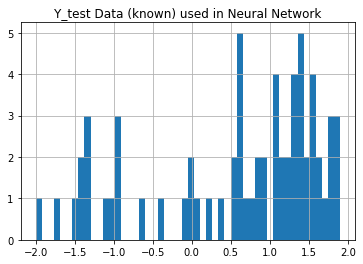

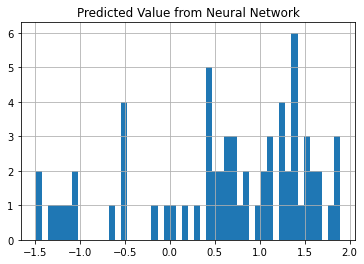

In [21]:
'''
Plots of test results
'''
# y_test is the normalized lMode data
plt.hist(y_test, 50)
plt.grid(True)
plt.title('Y_test Data (known) used in Neural Network')
plt.show()

# pred is the normalized predictions
plt.hist(pred, 50)
plt.grid(True)
plt.title('Predicted Value from Neural Network')
plt.show()

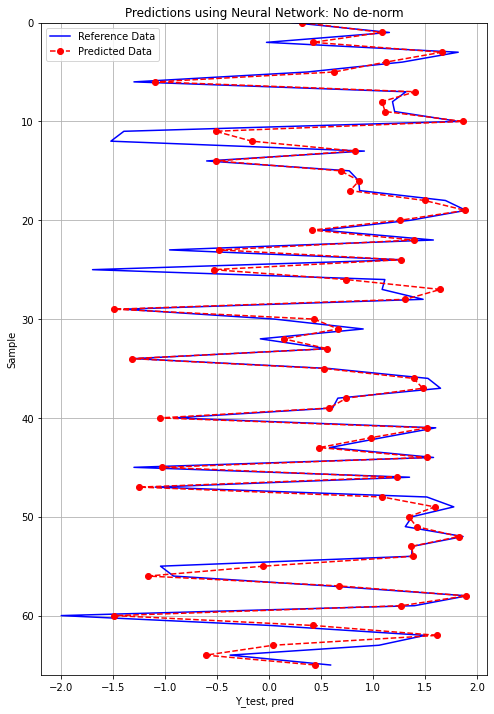

In [22]:
plt.figure(figsize=(8,12))
plt.plot(y_test, range(y_test.shape[0])         , label="Reference Data",c="b")
plt.plot(pred  , range(y_test.shape[0]), 'r--o' , label="Predicted Data")
plt.grid(True)
plt.ylim(len(y_test),0)

plt.legend(loc='best')
plt.xlabel('Y_test, pred')
plt.ylabel('Sample')
plt.title('Predictions using Neural Network: No de-norm')
plt.show()

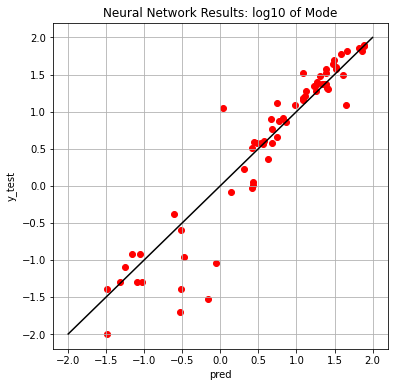

In [23]:
plt.figure(figsize=(6,6))
#plt.scatter(pred, y_test,  c="r")
plt.scatter(pred, y_test,  c="r")
plt.plot([-2,2],[-2,2], c="k")
#m, b = np.polyfit(pred, y_test,1)
#plt.plot(pred, m*pred + b)
plt.grid(True)
plt.ylabel('y_test')
plt.xlabel('pred')
plt.title('Neural Network Results: log10 of Mode')
plt.show()

In [24]:
print(max(pred),min(pred),len(pred))

[1.8935537] [-1.4892876] 66


## Save csv results:

In [25]:
savetxt('./data/Mode_tf_estimate.csv', pred, delimiter =',')
#savetxt('AllData_with_Predictions.csv',df_test, delimiter =',')

---
#  Now we can use the saved epoch training checkpoing results and predict the Mode of the PTD for all data or even other data. We will use Sklearn norm of Porosity and of log10 of Perm to make our estimation of log10 of Mode.
**This section does the estimation from the saved checkpoint data**
That is it!!!!

In [26]:
with tf.Session() as sess:
    saver.restore(sess,'./data/rosettastone_dataset.ckpt')    
    pred2   = sess.run(output, feed_dict = {xs:scaled_features})    

INFO:tensorflow:Restoring parameters from ./data/rosettastone_dataset.ckpt


2022-03-09 20:14:38.350227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 20:14:38.350245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-09 20:14:38.352801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-09 20:14:38.357166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
print(max(pred2),min(pred2),len(pred2))

[2.0736372] [-1.4892876] 328


## Creat a DataFrame for  pred2 for all data for the entirre Rosetta Stone database:

In [28]:
df_pred  = pd.DataFrame(pred2         , columns=['pred2'])
df_labels = pd.DataFrame(correct_labels, columns=['labels'])

#df_pred2 = pd.DataFrame()
#df_pred2['pred2']  = df_pred
#df_pred2['labels'] = df_labels
#df_pred2.head(328)

## Cross Plot of predicted normalized vs. actual normalized lMode and calculate r2:

Linearl Fit: y = m * x + b
	a = popt[0] = 1.0
	b = popt[1] = 1.0
        r2 = 0.885



/Users/craig/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


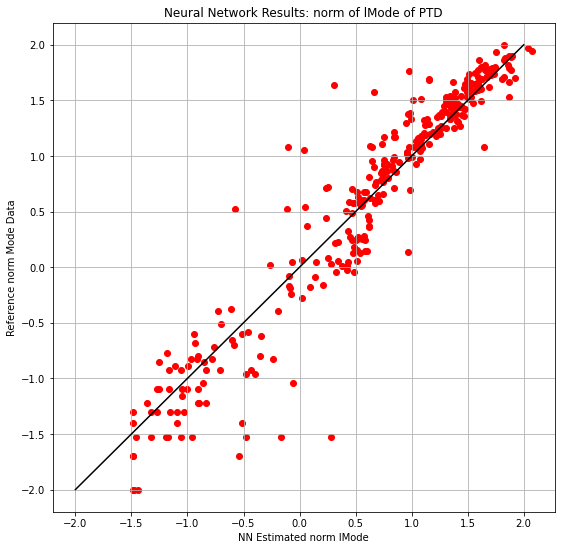

In [29]:
from scipy.optimize import curve_fit

newX = np.linspace(-2,2 )

def MyLinFunc(x, m, b):
    return m * x + b

popt, pcov = curve_fit(MyLinFunc, df_pred['pred2'], df_labels['labels'])
print("Linearl Fit: y = m * x + b")
print("\ta = popt[0] = {0}\n\tb = popt[1] = {1}".format(*popt))

popt[1]=0

# r2 calculations https://newbedev.com/getting-the-r-squared-value-using-curve-fit
#residuals = ydata- f(xdata, *popt)
#ss_res = np.sum(residuals**2)
#ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared = 1 - (ss_res / ss_tot)
residuals = df_pred['pred2']- MyLinFunc(df_labels['labels'], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df_pred['pred2']-np.mean(df_labels['labels']))**2)
r_squared = 1 - (ss_res / ss_tot)
print('        r2 =',round(r_squared,3))
print()


plt.figure(figsize=(9,9))
#plt.scatter(pred, y_test,  c="r")
plt.scatter(df_pred['pred2'], df_labels['labels'], c='r')
plt.plot(newX, MyLinFunc(newX, *popt), 'k-', label="({0:.3f}*x + {1:.3f})".format(*popt))
#plt.plot([.0,1],[.0,1], c="k")
#m, b = np.polyfit(pred, y_test,1)
#plt.plot(pred, m*pred + b)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
plt.ylabel('Reference norm Mode Data')
plt.xlabel('NN Estimated norm lMode')
plt.title('Neural Network Results: norm of lMode of PTD')
plt.show()


# Use this technique to de-normalize the data as a part of the original Sklearn method:
**Both techniques give the same results**

In [30]:
def denormalize(df,norm_data):
    df = df['lMode'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    #scl = MinMaxScaler()
    scl = MinMaxScaler(feature_range=(-2, 2))
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    print(scl)
    return new

In [31]:
pred3   = denormalize(df, pred2)

MinMaxScaler(feature_range=(-2, 2))


## Depth Plot of log10 of estimated Mode:

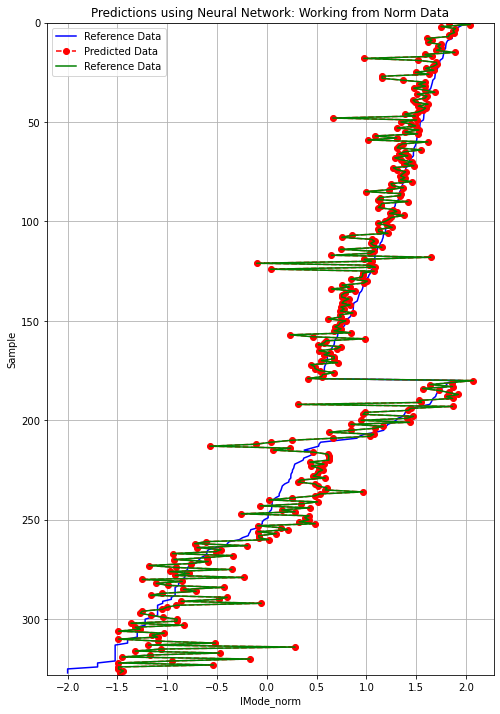

In [32]:
'''
Plots of test results
'''
PRT_plot = []

for i in range(len(pred2)):
    if pred2[i] > 0.62:
        PRT = 2
    elif pred2[i] < 0.35:
        PRT = -2
    else:
        PRT = 0
    
    PRT_plot.append(PRT)


plt.figure(figsize=(8,12))

#plt.plot(PRT_plot   , range(correct_labels.shape[0]), 'g-o',  label='PRT')
plt.plot(correct_labels , range(correct_labels.shape[0]),  label="Reference Data",c="b")
plt.plot(pred2   , range(correct_labels.shape[0]), 'r--o',  label="Predicted Data")
plt.plot(pred3        , range(correct_labels.shape[0]),  label="Reference Data",c="g")

plt.grid(True)
#plt.ylim(max(y_test.shape[0]),min(y_test.shape[0]))
plt.ylim(len(correct_labels),0)
#plt.xscale('log')


plt.legend(loc='best')
plt.xlabel('lMode_norm')
plt.ylabel('Sample')
plt.title('Predictions using Neural Network: Working from Norm Data')
plt.show()

## Calculate actual Mode of PTD:

In [33]:
Mode_est3 = 10**pred3

# De-normalize and Calculate Mode done a second technique:
**Same results as above, just a different way of doing it.**

In [34]:
lMode_est  = ((pred2/4 + 1/2)*(2-(-2)) + (-2))
Mode_est   = 10**(lMode_est)

## Cross Plot Plot all de-normailzed results as actual Mode in microns:
**We multiplied Mode_est3*0.95 to add a little jitter so that we could see that both techniques give the same results. With no jitter, they are all at the same point.**

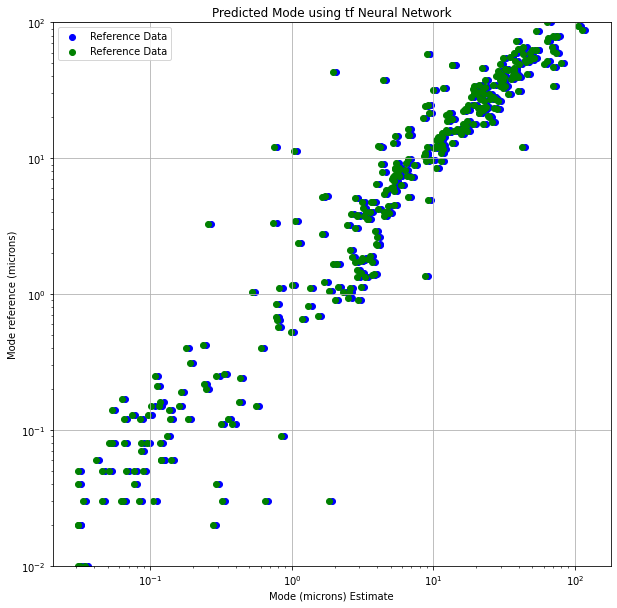

In [35]:
plt.figure(figsize=(10,10))

#plt.plot(PRT_plot   , range(correct_labels.shape[0]), 'g-o',  label='PRT')
plt.scatter(Mode_est, data['Mode'] ,   label="Reference Data",c="b")
plt.scatter(Mode_est3*0.95, data['Mode'] ,   label="Reference Data",c="g")  # see it better

#plt.plot(Mode_est   , range(correct_labels.shape[0]), 'r--o',  label="Predicted Data")

plt.grid(True)
plt.ylim( 0.01 , 100 )
plt.ylim( 0.01 , 100)
plt.xscale('log')
plt.yscale('log')

plt.legend(loc='best')
plt.xlabel('Mode (microns) Estimate')
plt.ylabel('Mode reference (microns)')
plt.title('Predicted Mode using tf Neural Network')
plt.show()

## Depth plot of estimated Mode data:

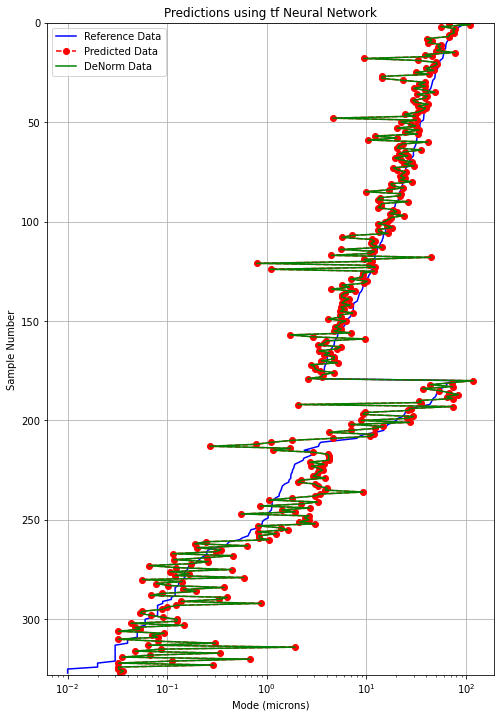

In [36]:
plt.figure(figsize=(8,12))

#plt.plot(PRT_plot    , range(correct_labels.shape[0]), 'g-o',  label='PRT')
plt.plot(data['Mode'] , range(correct_labels.shape[0]),  label="Reference Data",c="b")
plt.plot(Mode_est     , range(correct_labels.shape[0]), 'r--o',  label="Predicted Data")
plt.plot(Mode_est3    , range(correct_labels.shape[0]), 'g-',  label="DeNorm Data")




plt.grid(True)
#plt.ylim(max(y_test.shape[0]),min(y_test.shape[0]))
plt.ylim(len(correct_labels),0)
plt.xscale('log')


plt.legend(loc='best')
plt.xlabel('Mode (microns)')
plt.ylabel('Sample Number')
plt.title('Predictions using tf Neural Network')
plt.show()

## Save results:

In [37]:
savetxt('./data/raw_tf_est.csv', Mode_est, delimiter =',')